<h1><center>Layerwise Profiling By Model Reconstruction</center></h1>
<strong>28/6/2019</strong>

<strong>Report Author</strong>: Omar Alama

# Overview

In this report, I will showcase and document me and Ahmed's findings and observations while using the model reconstruction idea to get the layerwise costs of the a model for the past week.

The model reconstruction idea proposed by Marco is done as follows, we simply take an existing model with N layers, and then construct a model with the first layer, we run the functions and record the time costs, we then add the second layer and so on untill we have added all N layers.

The main intuition behind this idea was that if we had a model with 5 layers for example, [1,2,3,4,5] the difference in cost between the model with layers [1] and [1,2] will give us the cost of layer 2 in the final model. And the difference between [1,2] and [1,2,3] will give us the cost of layer 3 and so on.

The idea is also built on my assumption that the three available keras functions do the following:
- *predict*: calculates the output
- *evaluate*: calculates the output -> calculates the loss
- *fit*: calculates the output -> calculates the loss -> calculates the gradient -> applies the gradient

I used tensorflow 1.13.1 & 1.14

I used the VGG16 model for all our profiling since it is the simplest of the models and can be more easilly interpretable.

The report is devided to show how the profiling scheme evolved. Documenting the development and the problems faced helps us to avoid repeating the same mistakes. I took the time to write it down for myself mostly but also for you guys and anyone who is working on a similar problem. Nevertheless If you are in a hurry skip to the final profiling scheme numbered 4.

## Define functions

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [58]:
def print_report_info(report_path):
    with open(report_path) as file: 
        report = json.load(file)
    print("{:15}: {}".format("host",report["host"]))
    for item in report["args"].items():
        print("{:15}: {}".format(*item))

### Plot batch layer cost vs time
For debugging purposes. The cost should be almost constant or at least show no correlation with time. This is to ensure that memory is not leaking and that the performance does not get worse with each subsequent trial or batch.

In [113]:
def plot_cost_vs_time(report_path, title=None, cols=2, skip_first_layer=False,
                      skip_first_batch = False, skip_first_batch_in_each_trial=False):
    time_multiplier=1e3
    with open(report_path) as file: 
        report = json.load(file)
    timings = report["timings"]
    if "samples" in report["args"]:
        normalizing_factor = report["args"]["samples"] * time_multiplier
    else:
        normalizing_factor = report["args"]["batch_size"]*report["args"]["num_of_batches"] * time_multiplier
    costs = set(list(timings.values())[0].keys()) - {"Type"}
    plt.figure(figsize=(16,4 * np.ceil(len(costs)/cols)))
    c = 1
    for cost_name in costs:
        import math
        plt.subplot(np.ceil(len(costs)/cols), cols, c)
        c += 1
        for layer_name in list(timings.keys())[(1 if skip_first_layer else 0):]:
            data = timings[layer_name][cost_name]
            if skip_first_batch_in_each_trial:
                for i in range(report["args"]["trials"]):
                    data.pop(i*report["args"]["num_of_batches"] - i)
            elif skip_first_batch:
                data = data[1:]
            data = np.array(data) / normalizing_factor
            plt.plot(range(len(data)),  data, label=layer_name)
        plt.xlabel("Batch NO")
        plt.ylabel("Time per batch (us)")
        plt.xticks(range(len(data)))
        #plt.legend()
        if title == "":
            plt.title(cost_name)
        else:
            plt.title("{}: {}".format(title if title else report_path, cost_name))
    plt.show()

### Plot layer wise costs
Which is our targetted info. In all timings, the model is being built layer by layer from input to output (Left to right in the graph).

The last layer added name is shown on the x-axis. The accumulative cost is shown so no difference is taken.

Mean & standard deviation of all readings are plotted

In [114]:
costs = ["data_generation_cost", "forward_pass_cost", "backward_pass_cost", "output_calculation_cost",
         "loss_calculation_cost","gradient_calculation_cost", "gradient_application_cost", "predict",
         "evaluate","fit"]
def plot_layer_wise_costs(report_path, title=None, skip_first_layer=False, stacked=False, width=0.7,
                          skip_first_batch = False, skip_first_batch_in_each_trial=False):
    with open(report_path) as file: 
        report = json.load(file)
    time_multiplier = 1e3
    timings = report["timings"]
    N = len(timings) - (1 if skip_first_layer else 0)
    if "samples" in report["args"]:
        normalizing_factor = report["args"]["samples"] * time_multiplier
    else:
        normalizing_factor = report["args"]["batch_size"]*report["args"]["num_of_batches"] * time_multiplier
    means = dict()
    stds = dict()
    xticks = list()
    for layer_name in list(timings.keys())[(1 if skip_first_layer else 0):]:
        for cost_name in costs:
            if not cost_name in timings[layer_name].keys():
                continue
            if cost_name not in means.keys():
                means[cost_name] = list()
            if cost_name not in stds.keys():
                stds[cost_name] = list()
            data = timings[layer_name][cost_name]
            if skip_first_batch_in_each_trial:
                for i in range(report["args"]["trials"]):
                    data.pop(i*report["args"]["num_of_batches"] - i)
            elif skip_first_batch:
                data = data[1:]
            data = np.array(data) / normalizing_factor
            means[cost_name].append(np.mean(data))
            stds[cost_name].append(np.std(data))
        xticks.append(layer_name)

    plt.figure(figsize=(16,8))
    ind = np.arange(N)    # the x locations for the groups
    
    if stacked:
        accumulated_means = np.zeros(shape=N)
        for cost in means.keys():
            p = plt.bar(ind, means[cost], width, yerr=stds[cost], bottom=accumulated_means, label=cost)
            accumulated_means += means[cost]
    else:
        n = len(means)
        for j, cost in enumerate(means.keys()):
            p = plt.bar(ind - width/2 + width/n*j, means[cost], width/n, yerr=stds[cost], label=cost)
    plt.ylabel('Time per batch (us)')
    plt.xlabel("Last added layer")
    if title == "":
        plt.title(cost_name)
    else:
        plt.title("{}: {}".format(title if title else report_path, cost_name))
    plt.xticks(ind, xticks, rotation="vertical")
    plt.legend()
    plt.axhline(0, color='black')
    plt.show()

# Profiling Scheme 0
In this scheme we simply used the following scheme for timing:
```
t = time.time_ns()
function()
cost = time.time_ns() - t
```

# Profiling Scheme 1
In this scheme we simply used the following scheme for timing:
```
t = time.time_ns()
function()
cost = time.time_ns() - t
```
We used the tensorflow session and ran the computational graph by calling the 3 functions mentioned. Unfortunetly,
dummy input and output data generation is included in the computational graph and therefore in all of the costs.

### GPU

host           : mcnode38
model          : VGG16
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : gpu
batch_size     : 32
num_of_batches : 10
num_calls      : 1
trials         : 5
out            : None
log            : None


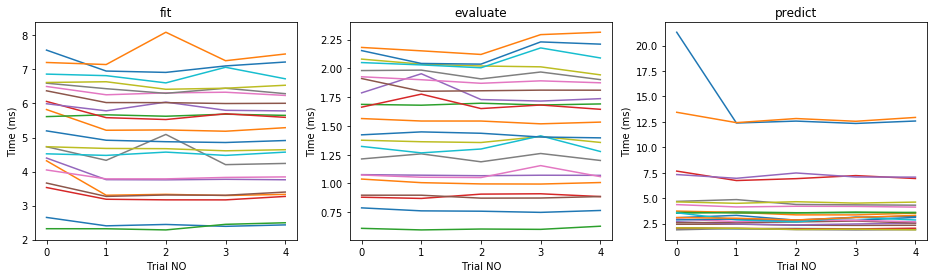

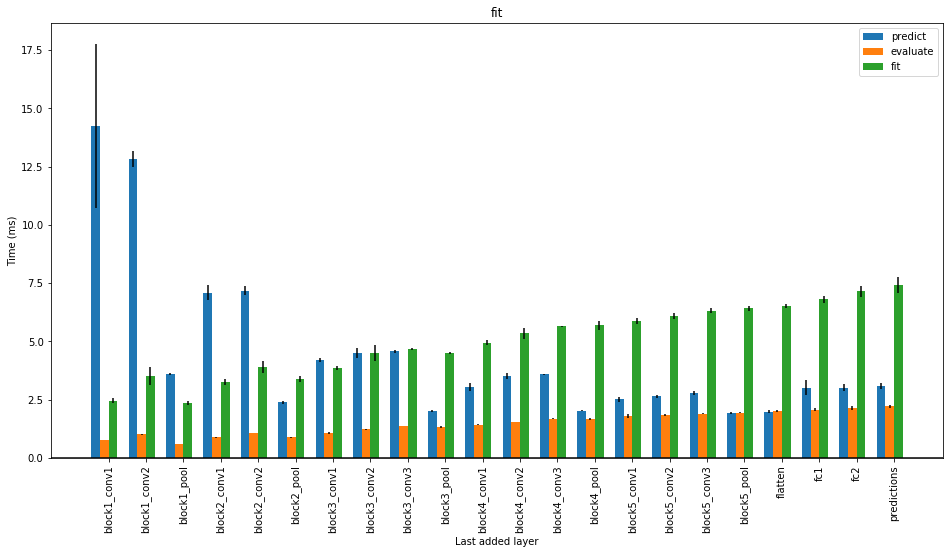

In [66]:
report_path = "timings/VGG16_06-26-12-22.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3)
plot_layer_wise_costs(report_path, title="")

### CPU

host           : mcnode40
model          : VGG16
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : cpu
batch_size     : 8
num_of_batches : 5
num_calls      : 1
trials         : 5
out            : None
log            : None


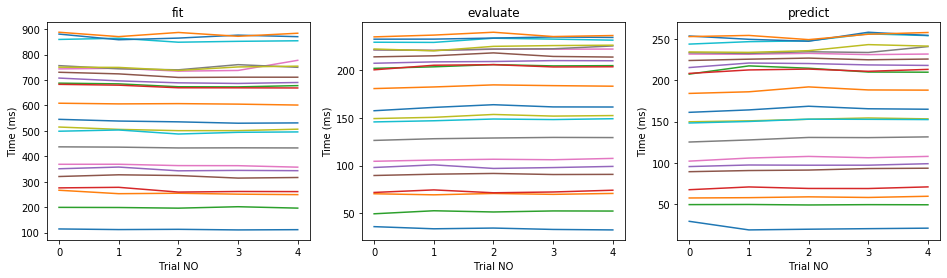

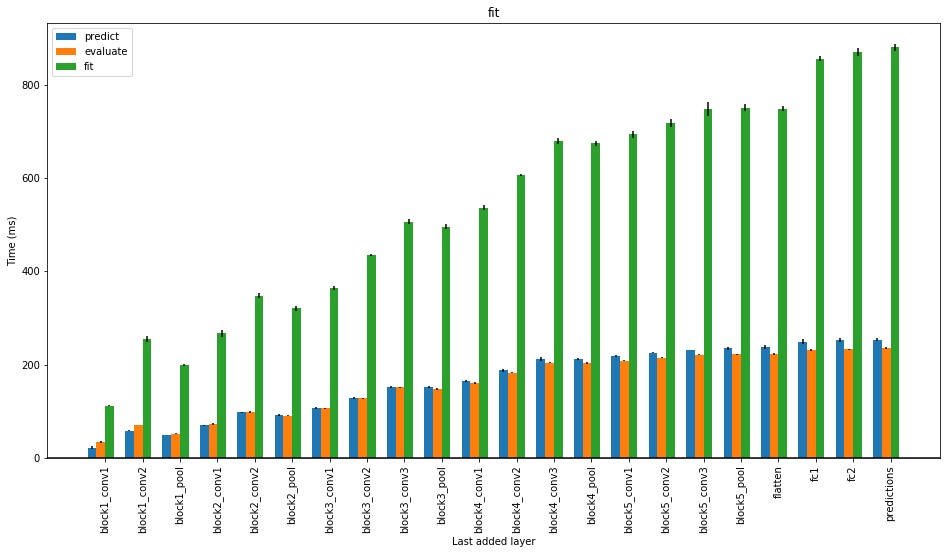

In [67]:
report_path = "timings/VGG16_06-26-15-00.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3)
plot_layer_wise_costs(report_path, title="")

### Key observations:
- There seems to be no correlation of cost with the number of trial which assures us that our trials are independent and that objects are not accumulating in memory. This was not actually the case because a problem with tensorflow graphs is that they never get reset unless instructed explicitly. So the computational graph was growing with each trial and filling up memory. Only after reseting the graph with each trial did we achieve this independence.
- Pooling layers seem to have negative cost that is adding it actually reduces total running time. Which defies our intuition.
- Other than pooling layers, the CPU results match our intution for the most part however the GPU results are far from it.
- Prediction seems to have a longer time than fitting in gpus and evaluation in both gpu and cpu for some layers which again defies our intuition.

### Next: 
At this point I suspected that data generation with each run could be affecting our timings. So we needed to exclude that cost from our computational graph however according to tensorflow, tensors generated in a session must be used in that session so we cannot generate the data in a different untimed session.

So we move on to eager execution mode in tensorflow, which simply means that commands are run instantly instead of building a computational graph. This ensures that data generation does not get included in our costs.

# Profiling Scheme 2
Same timing scheme as in scheme 1
```
t = time.time_ns()
function()
cost = time.time_ns() - t
```
The only difference now is that tensorflow eager execution is enabled.

This also allows us to see the cost of data generation seperately.

### GPU

host           : mcnode40
model          : VGG16
loss           : binary_crossentropy
eager          : True
optimizer      : sgd
device         : gpu
batch_size     : 32
num_of_batches : 10
num_calls      : 1
trials         : 5
out            : None
log            : None


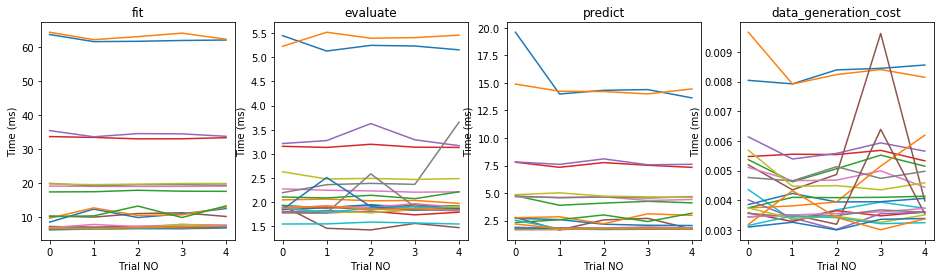

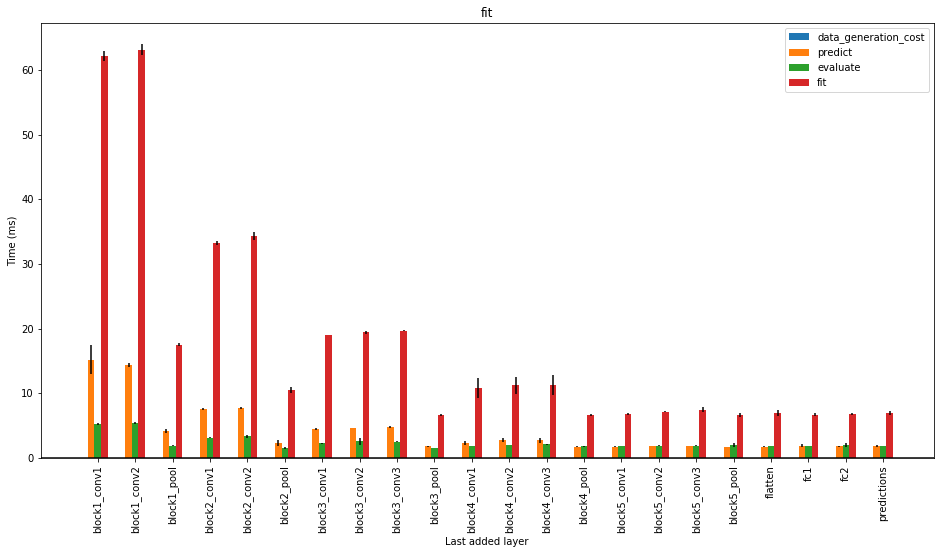

In [69]:
report_path = "timings/VGG16_06-26-12-28.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=4)
plot_layer_wise_costs(report_path, title="")

### CPU

host           : mcnode39
model          : VGG16
loss           : binary_crossentropy
eager          : True
optimizer      : sgd
device         : cpu
batch_size     : 8
num_of_batches : 5
num_calls      : 1
trials         : 5
out            : None
log            : None


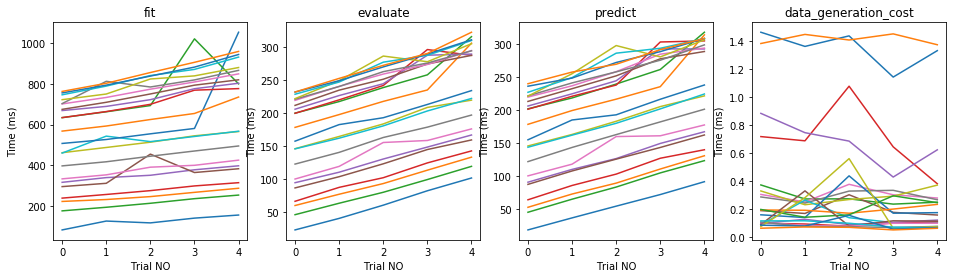

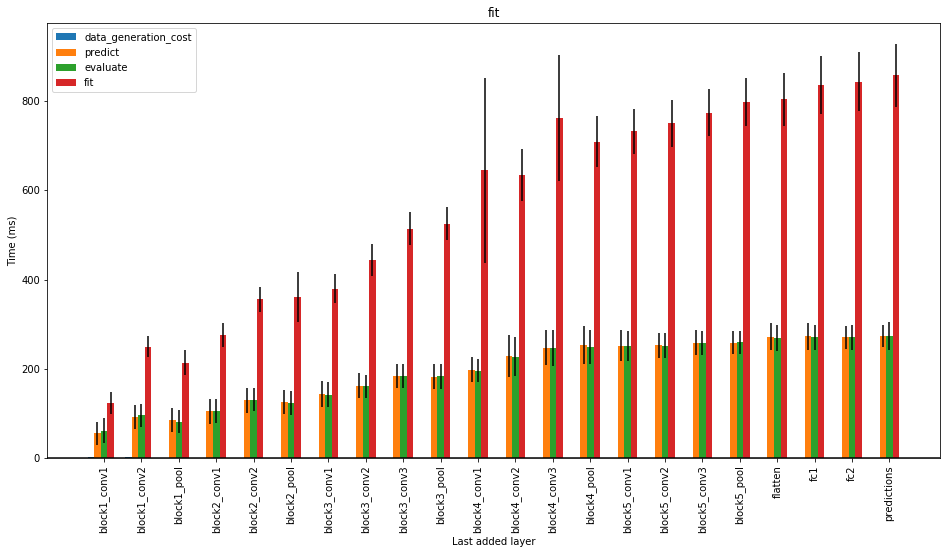

In [70]:
report_path = "timings/VGG16_06-26-15-28.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=4)
plot_layer_wise_costs(report_path, title="")

### Key observations:
- Eager execution significantly increases the time for function runs on a GPU
- Eager execution shows a slowing effect with the number of trials therefore trials are not independent. This most likely indicates a bad implementation on my part however I was not able to deduce the issue.
- Eager execution results for a CPU match normal execution and is consistent and inline for the most part with our intuition, however the GPU results are still largely different and insconsistent defies our intuition completely.
- Pooling layers still reduce time which still defies our intuition
- Evaluation sometimes takes less than prediction which still defies our intuition.
- Data generation cost is negligible and probably did not effect the timings in scheme 1.

### Next: 
Ahmed suspected that our timing scheme is inaccurate especially for GPUs since the timing is done on the CPU and the functions run on the GPU. And CPUs are prone to context switching and are unpredictable. We then confirmed this suspicion with generating a trace for the runs and have noticed a huge difference in the time measured using our scheme and the total time in the trace.

So I decided to try two approaches.
- Extract the total duration from the trace info and use that instead of the time module. The problem with this is that only the last batch is recorded. However, I found that keras supports on_batch_begin and on_batch_end callbacks so I used those to get access to the traces of all batches.
- I use the same python time module however this time I use keras callbacks.

# Profiling Scheme 3
In this scheme we use the same python time module however we use **on_batch_begin** and **on_batch_end** callbacks to get the duration.

Notice that now we have access to batch running time instead of the total execution time.

This scheme can be used in conjunction with eager execution as well however I did not generate any timings for that.

Without eager execution, data generation is included in the costs but it is assumed to be negligible.

### GPU

host           : mcnode39
model          : VGG16
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : gpu
batch_size     : 32
num_of_batches : 20
trials         : 5
skip           : False
use_tracer     : False
out            : None
log            : None


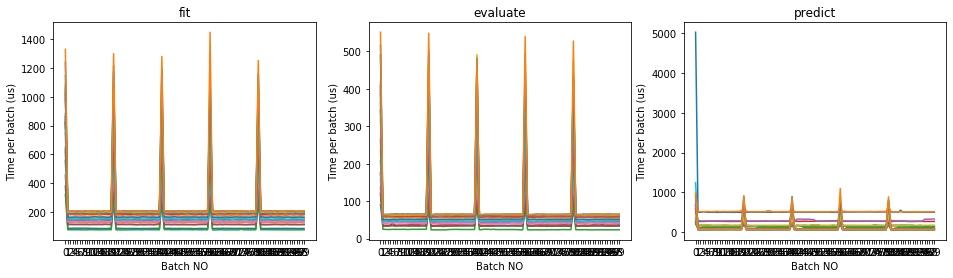

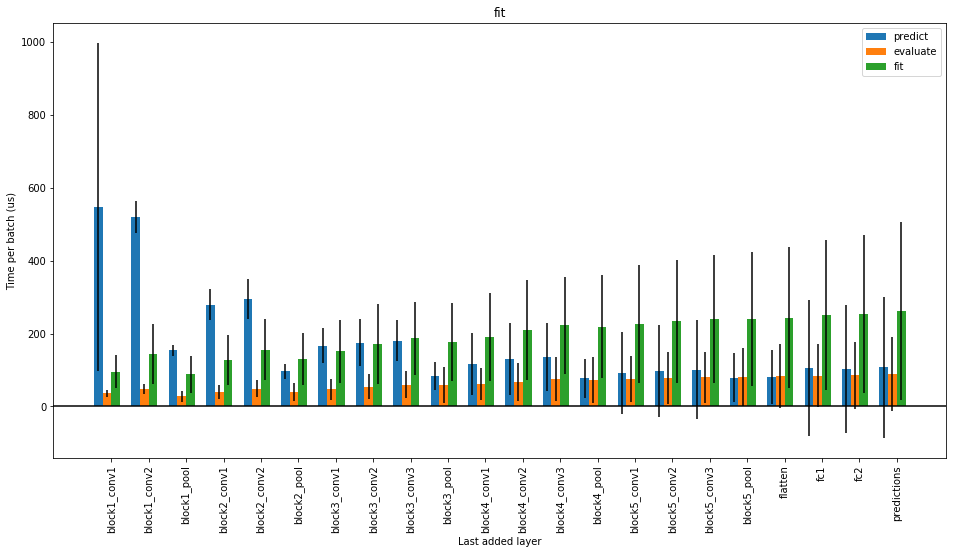

In [91]:
report_path = "timings/VGG16_06-27-13-58.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3)
plot_layer_wise_costs(report_path, title="")

### CPU

host           : mcnode39
model          : VGG16
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : cpu
batch_size     : 8
num_of_batches : 10
trials         : 5
skip           : False
use_tracer     : False
out            : None
log            : None


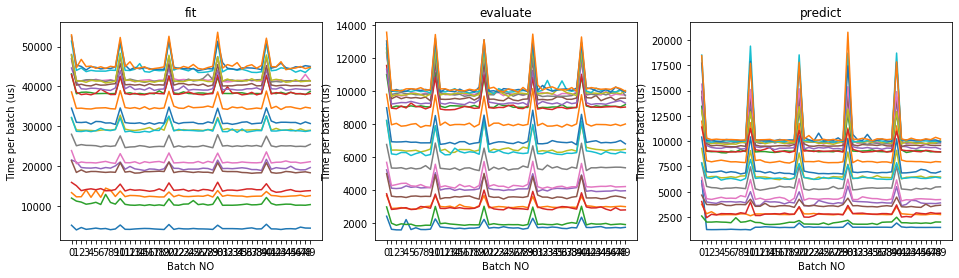

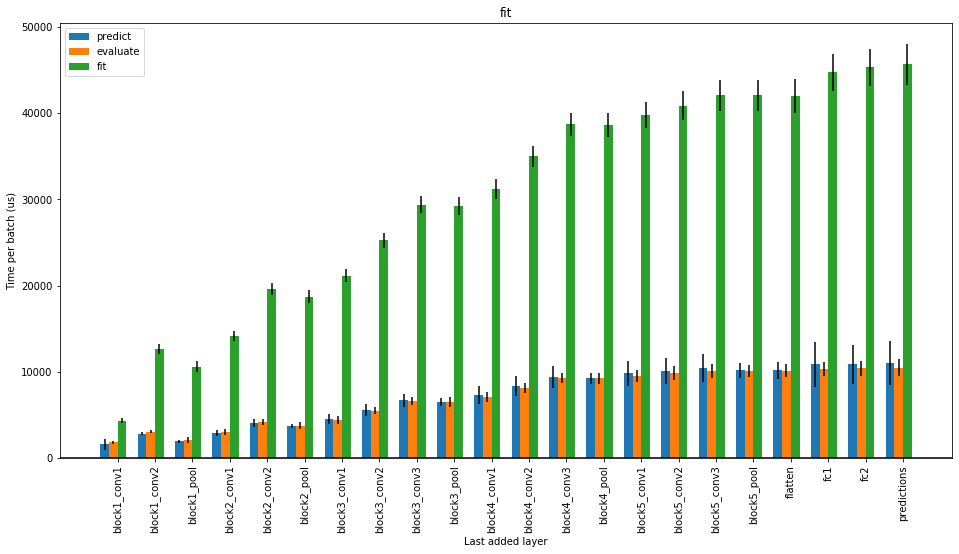

In [119]:
report_path = "timings/VGG16_06-27-15-14.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3)
plot_layer_wise_costs(report_path, title="")

### Key observations:
- The first batch cost in each trial is an outlier and is much larger than all other batches costs
- Very high variance which makes it impossible to deduce anything.

### Next:
- High variance is most likely due to the first batch in each trial. Therefore we should ignore it in our analysis or include a warmup batch in our profiling tool to cutoff this value completely. Let us ignore it for now and display the results.

### GPU

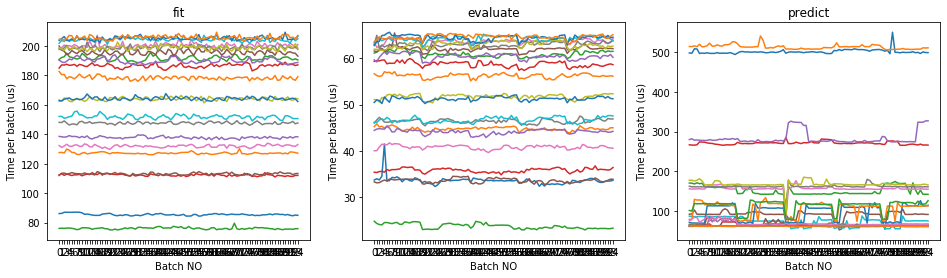

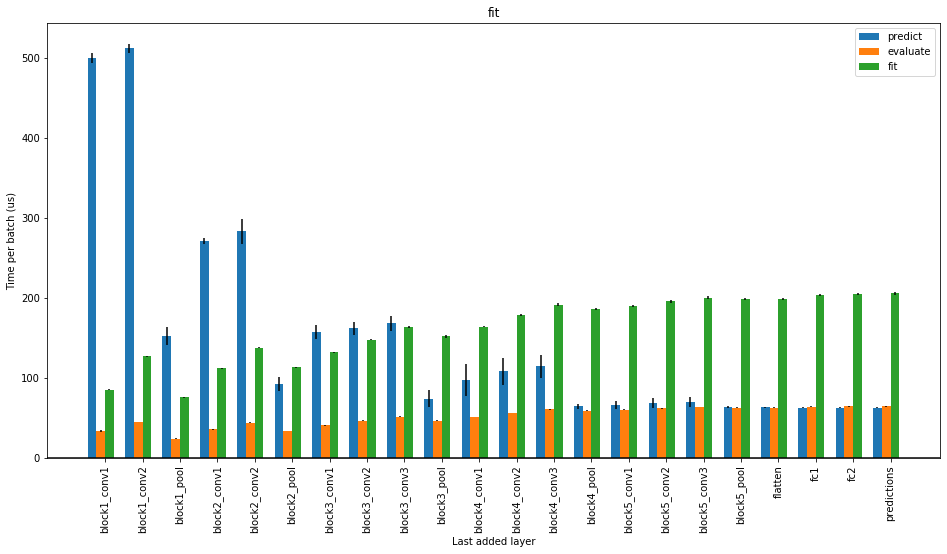

In [120]:
report_path = "timings/VGG16_06-27-13-58.timings.json"
plot_cost_vs_time(report_path,title="", cols=3, skip_first_batch_in_each_trial=True)
plot_layer_wise_costs(report_path, title="", skip_first_batch_in_each_trial=True)

### CPU

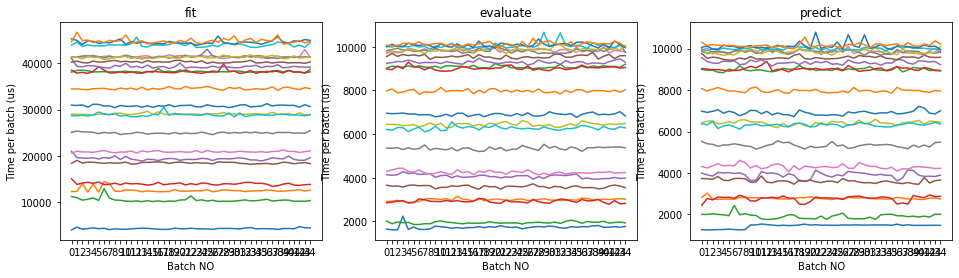

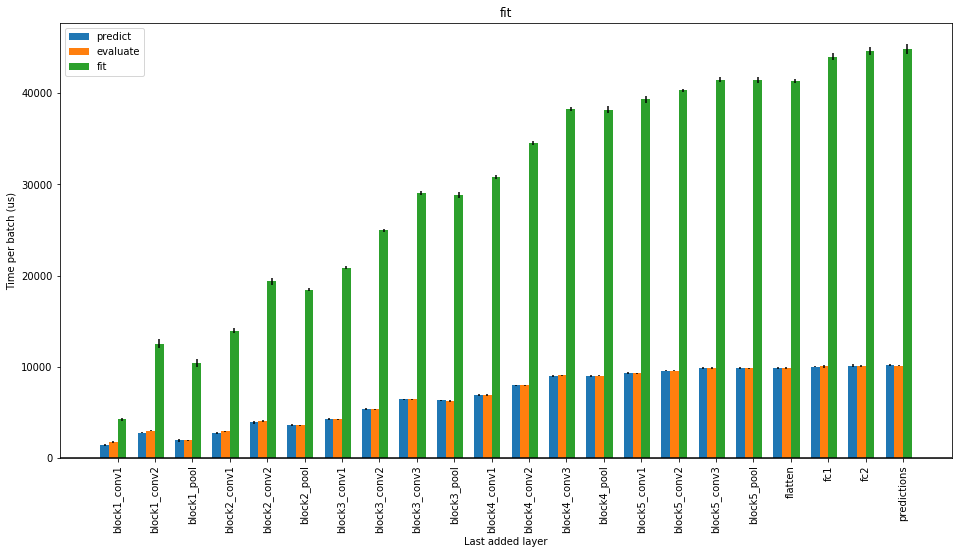

In [121]:
report_path = "timings/VGG16_06-27-15-14.timings.json"
plot_cost_vs_time(report_path,title="", cols=3, skip_first_batch_in_each_trial=True)
plot_layer_wise_costs(report_path, title="", skip_first_batch_in_each_trial=True)

### Key observations:
- Removing the first batch of each trial cuts off variance completely. We can now parse the graph.
- The cost now appears to be constant without correlation with batch number or trial.
- Pooling layers continue without fail to reduce run time.
- For the gpu, The values of prediction are still much much higher than fitting in the first half of the network which again defies our intution. It is also higher than evaluation for the most part of the network. The only explanation I can think of for this is that perhaps since prediction is the only function that returns values, then the large cost is due to the values being transfered from the GPU to the CPU so that it is displayed or used in python.
- For the cpu, the functions are organized in the intuitive order and in what we would expect.

### Next:
- Try the tensorflow tracer approach.

# Profiling Scheme 4 (Final)
In this scheme we rely on the tracing information supplied by tensorflow to compute the duration as follows:
```
for event in trace_dict["traceEvents"]:
    if "ts" not in event:
        continue
    start_time = event["ts"]
    end_time = start_time + event["dur"] if "dur" in event else 0
    if end_time > mx:
        mx = end_time
    if start_time < mn:
        mn = start_time
return (mx - mn)
```
This approach cannot be used with eager execution.

Data generation is also included in the costs but it is assumed to be negligible.

### GPU

host           : mcnode40
model          : VGG16
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : gpu
batch_size     : 32
num_of_batches : 20
trials         : 5
skip           : False
use_tracer     : True
out            : None
log            : None


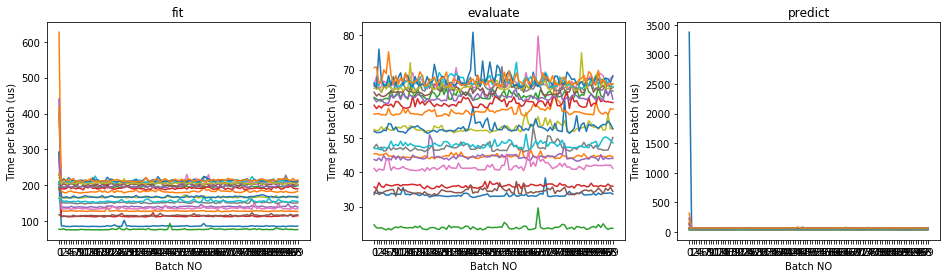

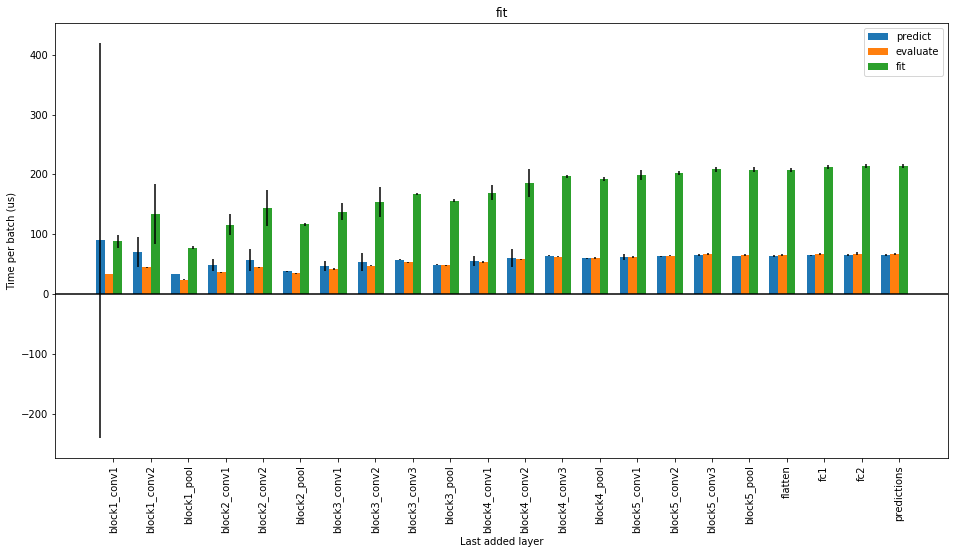

In [117]:
report_path = "timings/VGG16_06-27-14-01.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3)
plot_layer_wise_costs(report_path, title="")

### CPU

host           : mcnode40
model          : VGG16
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : cpu
batch_size     : 8
num_of_batches : 10
trials         : 5
skip           : False
use_tracer     : True
out            : None
log            : None


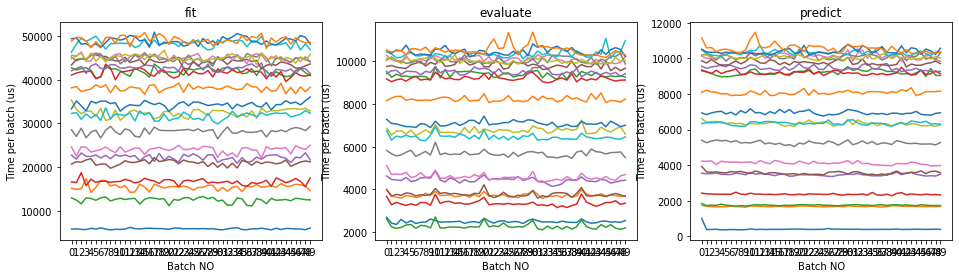

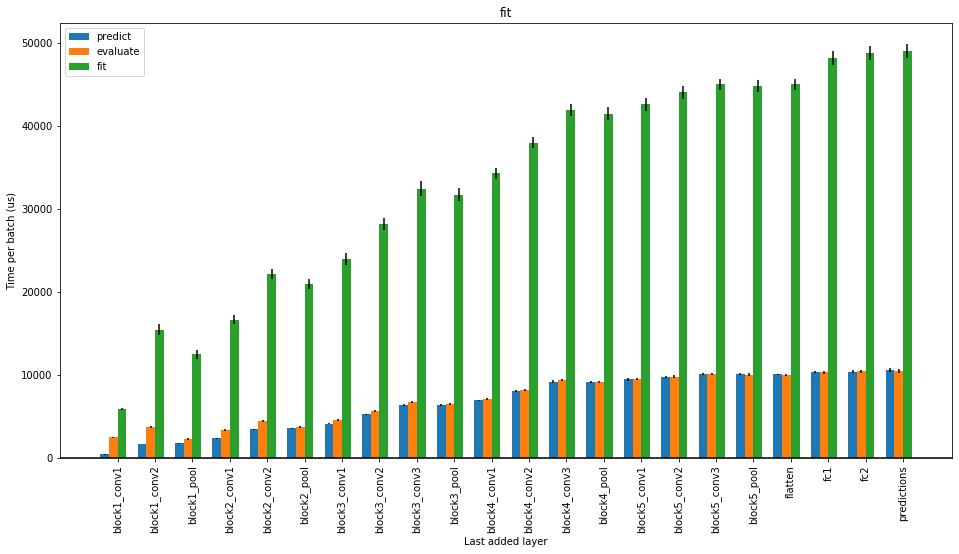

In [122]:
report_path = "timings/VGG16_06-27-15-20.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3)
plot_layer_wise_costs(report_path, title="")

### Key observations:
- Unlike in scheme 3, CPU run has no outliers & GPU run only has the very first batch as an outlier.
- CPU results seem to be independent of batch number and trial

### Next:
- Remove first batch and continue

### GPU

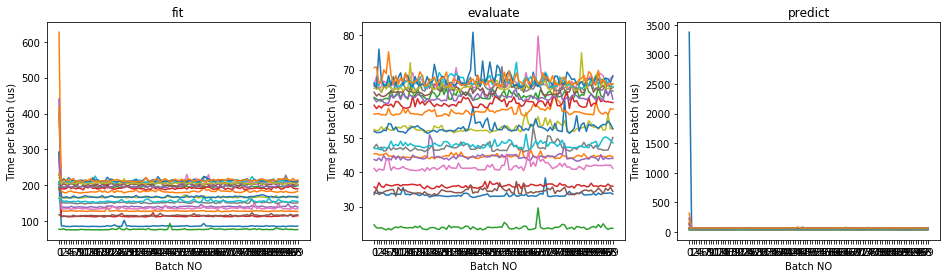

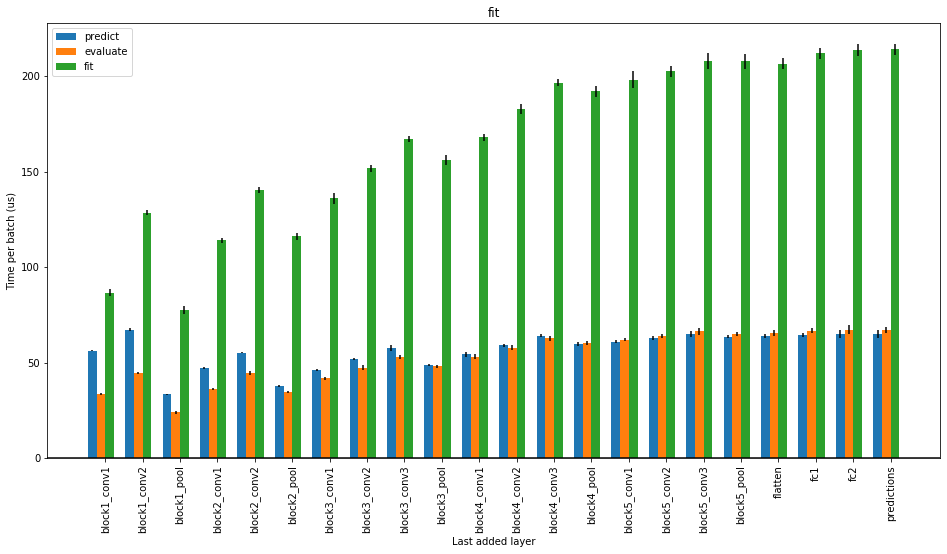

In [125]:
report_path = "timings/VGG16_06-27-14-01.timings.json"
plot_cost_vs_time(report_path,title="", cols=3)
plot_layer_wise_costs(report_path, title="", skip_first_batch=True)

### CPU

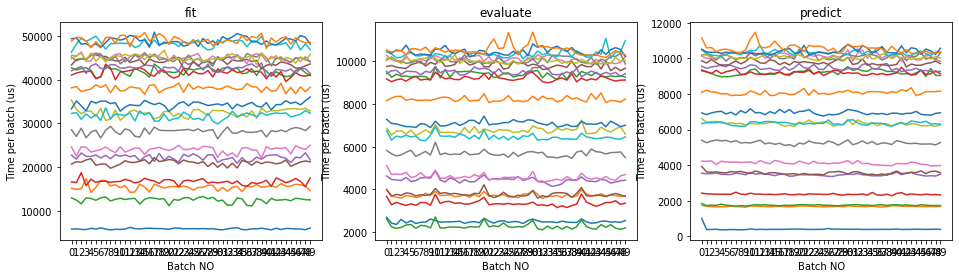

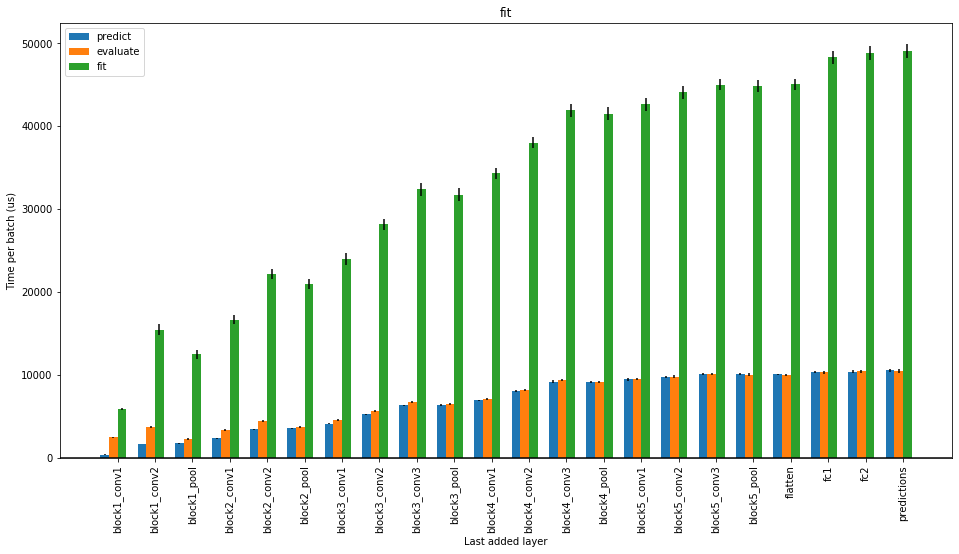

In [126]:
report_path = "timings/VGG16_06-27-15-20.timings.json"
plot_cost_vs_time(report_path,title="", cols=3)
plot_layer_wise_costs(report_path, title="", skip_first_batch=True)

### Key observations:
- CPU results do not seem to be affected, As for the GPU results, the batches and trials seem to be independent which of course gives more credibility to our GPU readings.
- Variance achieved is the lowest amongst all schemes.
- Pooling layers still reduce running time cost which defies our intuition.
- Gives us the only graph where prediction is never higher than fitting which matches our intution.
- Evaluation is still lower than prediction in some cases which defies our intuition

### Next:
- The last suspicion that I have is that maybe bigger models are reusing tensors from previous smaller models. We can remove this suspicion by doing a fully independent run of the first two layers of VGG. By fully I mean a different python process.

# Conclusions
1. The final profiling scheme seems to achieve the most accurate and reliable results and should be used as the default method.
- The negative costs of pooling layers which can be observed in all gpu and cpu reports without fail indicates one of two things.
  - The assumption that adding a layer adds cost is not be true. Some optimizations may be happening that actually reduce the total running time upon adding a certain layer.
  - The assumption holds however the model reconstruction approach fails to capture the costs of a layer since it does not measure layer costs with the full model built
- For GPU results, The fact that prediction takes more time than evaluation even with tracing information is unexplainable not even by the cpu to gpu memory transfer explaination since that is not included in the tracing.
- The model reconstruction approach generates consistent results for both GPUs and CPUs however only the CPU runs match our intution in terms of the costs of the three functions.
- We cannot however trust this approach completely and try to change our assumptions and understanding yet. We should try another more reliable approach first which will either validate or invalidate the results found here.

# Next
I cannot imagine anymore improvements that we can make to this approach. The results are consistent with a very low variance.
Nevertheless things we can do to gain more insight with:
1. Generate timings for other architectures like resnet or inception and see what other insights we can draw. Profiling VGG16 for example gave us the pooling layer insight. Could there be other abnormalities that defy our intution? 
- Use the same approach but reconstruct from output to input instead and see what results we get. This will only help us understand the effect of pooling layers more but I doubt that it will bring us closer to our layer profiling goal.
- Use the timing technique however with 1 layer models only. So the model is not reconstructed by its layers are iterated and profiled. This, approach may be more viable however it will certainly ignore any parallelization done and any optimizations done for a fully built model.

However due to the short amount of time I have (5 Weeks), what I really recommend is to do one of the following:
1. Make due with the results we have and make some simplifying assumptions to make it work in the simulator.
- Continue trying to profile using the following method: Customize the tensorflow print primitive so that it prints in gradient calculation as well as output calclulation (The approach to making a custom tensorflow op is documented). This means we can use the keras lambda layer to inject this operation inbetween layers without having to deal with the hassle of a computational graph or a custom training loop. We can already use the lambda layer to get the forward pass info without the need for a custom operation. I expect this to take two days (But then again I also expected the model reconstruction approach to take 2 days and It took more than a week)
- Drop the profiling and generate networks in the simulator based on distributions no need for them to be realistic. This will help us see the gain of preemption as we adjust multiple knobs including:
  - Mini-batch size
  - Number of batches
  - computation units mean
  - computation size std
  - communication units mean
  - communication units std
  - Linearity of the network (How sequential it is)
- Drop the profiling and the simulation and start working on implementation

